# Implementing AlexNet Using PyTorch As A Transfer Learning Model In Multi-Class Classification

## 1. Walk-through of AlexNet
AlexNet famously won the 2012 ImageNet LSVRC-2012 competition by a large margin (15.3% VS 26.2% (second place) error rates). Here we have a look at the details of the neuron architecture from the related paper [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks).

### The highlights of the paper
1. Use Relu instead of Tanh to add non-linearity. It accelerates the speed by 6 times at the same accuracy.
2. Use dropout instead of regularisation to deal with overfitting. However the training time is doubled with the dropout rate of 0.5.
3. Overlap pooling to reduce the size of network. It reduces the top-1 and top-5 error rates by 0.4% and 0.3%, repectively.

### The architecture
It contains 5 convolutional layers and 3 fully connected layers. *Relu* is applied after very convolutional and fully connected layer. *Dropout* is applied before the first and the second fully connected year. The image size in the following architecutre chart should be $227 * 227$ instead of $224 * 224$, as it is pointed out by Andrei Karpathy in his famous CS231n Course. More insterestingly, the input size is 224 * 224 with 2 padding in the pytorch torch vision. The output width and height should be $(224–11+4)/4 + 1=55.25!$ The explanation here is pytorch Conv2d apply floor operator to the above result, and therefore the last one padding is ignored.

![alenet](https://miro.medium.com/max/875/1*qyc21qM0oxWEuRaj-XJKcw.png)

The following table shows different layers, parameters and computation units needed.

<img src="Alexnet.PNG" alt="Alenet" width="600"/>

The network has 62.3 million parameters, and needs 1.1 billion computation units in a forward pass. We can also see convolution layers, which accounts for 6% of all the parameters, consumes 95% of the computation. This leads [Alex’s another paper](https://arxiv.org/abs/1404.5997), which utilises this feature to improve performance. The basic idea of that paper is as follows if you are interested:

1. Copy convolution layers into different GPUs; Distribute the fully connected layers into different GPUs.
2. Feed one batch of training data into convolutional layers for every GPU (Data Parallel).
3. Feed the results of convolutional layers into the distributed fully connected layers batch by batch (Model Parallel) When the last step is done for every GPU. Backpropogate gradients batch by batch and synchronize the weights of the convolutional layers.

# 2. Implementation of AlexNet in PyTorch
Now, we are going to implement the pre-trained AlexNet model in PyTorch. Before proceeding further, make sure that you have installed the PyTorch successfully if you are working on your local system. But if you are working in Google Colab and using the hosted runtime, then the installation of PyTorch is not required on the local system.

In the next step, we are going to import the most important libraries. Remaining libraries will be imported along with the code segments for better describing the use of that library. In this first step, we will import the torch because we are going to implement our AlexNet model in PyTorch. The torchdivision library is required to import the dataset and other operations. The transforms library will be used to transform the downloaded image into the network compatible image dataset.

In [10]:
import torch
import torch.nn as nn
import torchvision # download the dataset and other operations
import torchvision.transforms as transforms  #loaded image into the network compatible image dataset.

Here, we are defining an object through which we can transform an image into the required image dataset that will be compatible with the **AlexNet model**. Using the below code snippet, the input image will be first converted to the size $256×256$ pixels and then cropped to the size $224×224$ pixels as the **AlexNet model** require the input images with size $224×224$. 
Finally, the image dataset will be converted to the PyTorch tensor data type. To normalize the input image data set, the mean and standard deviation of the pixels data is used as per the standard values suggested by the PyTorch.

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In the below code segment, the **CIFAR10 dataset** is downloaded from the PyTorch’s dataset library and parallelly transformed into the required shape using the transform method defined above. The DataLoader performs operations on the downloaded data such as customizing data loading order, automatic batching, automatic memory pinning, etc. 

In [3]:
#Downloading training data
train_data = torchvision.datasets.CIFAR10(root='./sample_data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

#Downloading test data
test_data = torchvision.datasets.CIFAR10(root='./sample_data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

#Class labels

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

Extracting ../data\cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Once the dataset is downloaded, we will visualize some random images from the dataset using the below function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


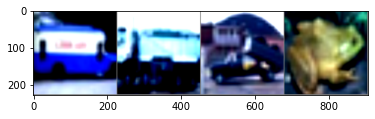

Truck Truck Truck  Frog


In [7]:
import matplotlib.pyplot as plt
import numpy as np

#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Once are confirm with the downloaded image dataset, we ill proceed further and instantiate the AlexNet model. For this purpose, the below code snippet will load the AlexNet model that will be pre-trained on the ImageNet dataset. 

In [8]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
AlexNet_model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\ADMIN/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

As we are going to use this network in image classification with the CIFAR-10 dataset, there will be 10 output class labels to be predicted by the network. For this purpose, we need to update the network because we can see in the above image, the final classifier label that is (6): Linear() is having the 1000 nodes at the output layer. This must be changed to 10. Along with this, we can see a very large number of nodes in the dense layers of the network (see the input and output features in the Linear() under classifier). This may cause the network to overfit or having heavy losses during the training. For this purpose, we will update the structure of each classifier using the below lines of codes.

In [11]:
#Updating the second classifier
AlexNet_model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
AlexNet_model.classifier[6] = nn.Linear(1024,10)

Once updated, we will gain check the description of the model

In [12]:
#Model description
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## CUDA
As we can see in the above description, the last to classifiers are updated and we have 10 nodes as the output features. To speed-up the performance during training, we will use the CUDA interface with GPU. 

In [13]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Now, we will define the optimizer and loss functions. Stochastic gradient descent will be used as an optimizer and cross-entropy will be used for the loss.

In [15]:
import torch.optim as optim

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

## Training the AlexNet
In the next step, we will train the AlexNet model using the below code snippet.

In [16]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

[1,  2000] loss: 1.184
[1,  4000] loss: 0.877
[1,  6000] loss: 0.778
[1,  8000] loss: 0.701
[1, 10000] loss: 0.664
[1, 12000] loss: 0.615
[2,  2000] loss: 0.465
[2,  4000] loss: 0.476
[2,  6000] loss: 0.490
[2,  8000] loss: 0.492
[2, 10000] loss: 0.477
[2, 12000] loss: 0.469
[3,  2000] loss: 0.318
[3,  4000] loss: 0.339
[3,  6000] loss: 0.346
[3,  8000] loss: 0.359
[3, 10000] loss: 0.328
[3, 12000] loss: 0.344
[4,  2000] loss: 0.215
[4,  4000] loss: 0.245
[4,  6000] loss: 0.240
[4,  8000] loss: 0.272
[4, 10000] loss: 0.264
[4, 12000] loss: 0.269
[5,  2000] loss: 0.149
[5,  4000] loss: 0.195
[5,  6000] loss: 0.180
[5,  8000] loss: 0.185
[5, 10000] loss: 0.209
[5, 12000] loss: 0.185
[6,  2000] loss: 0.126
[6,  4000] loss: 0.141
[6,  6000] loss: 0.157
[6,  8000] loss: 0.163
[6, 10000] loss: 0.154
[6, 12000] loss: 0.172
[7,  2000] loss: 0.096
[7,  4000] loss: 0.123
[7,  6000] loss: 0.128
[7,  8000] loss: 0.146
[7, 10000] loss: 0.143
[7, 12000] loss: 0.129
[8,  2000] loss: 0.102
[8,  4000] 

## Testing the AlexNet Model
Once the training is over, we will test the classification accuracy of our trained model on 10,000 test images.

In [17]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


So, as we can see above, the model has given 85% of accuracy in classifying the unseen test images when trained in 10 epochs. Now, we will check the classification accuracy of our model in classifying images of the individual classes.

In [18]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Airplane : 89 %
Accuracy of   Car : 94 %
Accuracy of  Bird : 73 %
Accuracy of   Cat : 70 %
Accuracy of  Deer : 89 %
Accuracy of   Dog : 78 %
Accuracy of  Frog : 91 %
Accuracy of Horse : 87 %
Accuracy of  Ship : 89 %
Accuracy of Truck : 87 %


In the end, we will match the average accuracy in classifying images of individual classes with the accuracy of the entire network.

In [19]:
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  85.08


## Saving model

In [20]:
torch.save(AlexNet_model, "AlexNet_model.weight")

## Conclusion
Finally, we can observe that the pre-trained AlexNet model has given the 85% accuracy in multiclass image classification. This accuracy can certainly be improved when we runt this training for more epochs say 100 or 200. That is far better than the AlexNet that we defined in the last article in Keras which was not using the pre-trained weights on the ImageNet dataset. So it can be concluded that the AlexNet model has a very good performance when it is used as a transfer learning framework. 